# Beta Banks Customer Retention
Prepared by Raphael Lu


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, confusion_matrix, make_scorer
from sklearn.utils import shuffle 
from sklearn.model_selection import GridSearchCV
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt


from pathlib import Path


In [2]:
filename = 'Churn.csv'
paths = [
    Path('../datasets'),
    Path.home() / 'Documents/Triple Ten Projects/my-portfolio/datasets'  # local fallback
]

loaded_from = None  # to store the path that worked

for path in paths:
    file_path = path / filename
    if file_path.exists():
        df = pd.read_csv(file_path)
        loaded_from = file_path  # save the path
        break
else:
    raise FileNotFoundError(f"{filename} not found in any of the specified paths.")

print(f"Data loaded from: {loaded_from}")

Data loaded from: ../datasets/Churn.csv


## Introduction

The purpose of this project is to assess the churn of bank customers at Beta Banks. Specifically, we will train models on data of past client behaviors to predict retention or loss of customers. 

Because we are dealing with a binary outcome (loss v retention), we will explore random decision trees using `RandomForestClassifier` from the `sklearn` library. In training our model, we will split available data using a 3:1:1 (train : validate : test) ratio. Paramters we will explore include n_estimators, tree depth, class balance, and threshold for positive prediction. We set our determinant for accuracy of the final model a priori at an F1 Score of 0.59.

Building a model that accurately predicts churn, will allow us to target customers for rention efforts.  


### Data Documentation Guide

**Features**
`RowNumber` — data string index  
`CustomerId` — unique customer identifier  
`Surname` — surname  
`CreditScore` — credit score  
`Geography` — country of residence  
`Gender` — gender  
`Age` — age  
`Tenure` — period of maturation for a customer’s fixed deposit (years)  
`Balance` — account balance  
`NumOfProducts` — number of banking products used by the customer  
`HasCrCard` — customer has a credit card (1 — yes, 0 — no)  
`IsActiveMember` — customer’s activeness (1 — active, 0 — inactive)  
`EstimatedSalary` — estimated salary

**Target**  
`Exited` — customer has left


## Initial Exploration of Data

Per initial view, we have historic data on 10,000 customers. Looking at our target metric, we see a class imbalance where only 20.4% of customers ended up leaving the bank.  

`RowNumber`, `CustomerId`, and `Surname` will be removed from the data set as they are not predictive of customer churn.  

`Gender`(k=2) and `Geography`(k=3) will be re-encoded using One Hot Encoding, dropping one class from each to avoid a "Dummy Feature Trap". 

In the data, we are also missing tenure information on 909 customers. Ostensibly there does not appear to specific shared characteristics amongst these individuals, however more exploration may need to be done. For the purposes if this analysis, NaN Tenure customers will be treated as a seperate category, with regard to tenure. 



In [3]:
display(df.info())
display(df.describe().iloc[[0,1,5,3,2,7]])

tenure_analysis = df.groupby('Tenure', dropna=False)['Exited'].agg(['count', 'mean'])
tenure_analysis.columns = ['Customer_Count', 'Exit_Rate']
tenure_analysis['Exit_Rate'] = tenure_analysis['Exit_Rate'].round(3)
display(tenure_analysis.T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Tenure,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,NaN
Customer_Count,382.000,952.000,950.000,928.000,885.000,927.000,881.000,925.000,933.000,882.00,446.000,909.000
Exit_Rate,0.236,0.224,0.195,0.213,0.208,0.202,0.201,0.173,0.186,0.22,0.206,0.201


### Catagorical Features



In [4]:
display (f"Unique Geographic Regions: {df['Geography'].unique()}")
display (f"Unique Genders: {df['Gender'].unique()}")

"Unique Geographic Regions: ['France' 'Spain' 'Germany']"

"Unique Genders: ['Female' 'Male']"

### Analysis of `NaN` values in Tenure

We will assess whether there is a statistically significant difference between the proportion of customers who have left the bank looking at customers with `NaN` Tenure years and customers with known Tenure years. For proportion comparison, we will use a Two-proportion Z-test and will set our hypotheses accordingly. We will set our alpha for statitical significance at 0.05. 
* H_0: There is no statistically significant difference between the proportions of customers who left the bank from Nan Tenure and Known Tenure
* H_A: There is a statistically significant difference between the proportions of customers who left the bank from Nan Tenure and Known Tenure.

\* For simplicity we did not use Chi-square analysis to assess differnce amongst all tenure years. Ostensibly, all tenure years appear to have ~20% churn rate so we assumed homogenaity amongst these years.   


In [5]:
group_nan = df[df['Tenure'].isna()]
group_non_nan = df[df['Tenure'].notna()]

churn_counts = np.array([group_nan['Exited'].sum(), 
                        group_non_nan['Exited'].sum()
                       ])

n_obs = np.array([len(group_nan),
                 len(group_non_nan)
                ])

stat, pval = proportions_ztest(churn_counts, n_obs, alternative='two-sided')
print(f"Z-Stat: {stat}, P-score: {pval}")

Z-Stat: -0.18685086273175583, P-score: 0.8517775664261061


Because our |Z-stat| is well below 1 and p-score is well above alpha, we fail to reject the null hypothesis and conclude that there is not a statistically significant difference in the proportion of customers who left the bank between our NaN and Known tenure groups.  

Accordingly, for this project we will assume that Tenure is not a key determinate for churn. Because both mean (4.99 years) and mode (5 years) are roughly equal (indicating symmetrical distribution of Tenure years), we will substitute `NaN` values with 5.0 years. 

In [6]:
df['Tenure'] = df['Tenure'].fillna(5.0)

## Data Preperation and Splitting


Data were split using a 3:1:1 ratio, resulting in 6000 entries for training and 2000 entries each of validation and final testing. 

In [7]:
df_clean = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)
df_ohe = pd.get_dummies(df_clean, drop_first=True)


train_valid, df_test = train_test_split(df_ohe, test_size = 0.20, random_state=42)
df_train, df_valid = train_test_split(train_valid, test_size=0.25, random_state=42)


print(f'Shape of Training Set: {df_train.shape}')
print(f'Shape of Validation Set: {df_valid.shape}')
print(f'Shape of Test Set: {df_test.shape}')

Shape of Training Set: (6000, 12)
Shape of Validation Set: (2000, 12)
Shape of Test Set: (2000, 12)


In [8]:

features_train = df_train.drop('Exited', axis=1)
target_train = df_train['Exited']

features_valid = df_valid.drop('Exited', axis=1)
target_valid = df_valid['Exited']

features_test = df_test.drop('Exited', axis=1)
target_test = df_test['Exited']


## Initial Model Training (Without Regard to Class Balance)

Data were first fit using `GridSearchCV` on models with n_estimator of size 100, 200, 300, 500, 600, and 700 with tree depths 5 to 20 (increasing by 5's). The best model from this round (n-estimator size: 200, depth: 20) resulted in a F1 score of 0.609 when test against the validation data. While this as already past our threshold, futher testing were performed in attempt to improve the model.

A second round of interations were performed. This time with n-estimator sizes from 125 to 275 (increasing by 25 step-wise) and with tree depths 5 to 20 (increasing by 5's). The best model from this round (n-estimator size: 250, depth: 20) resulted in a slightly improved accuracy score of 0.612 when test against the validation data. 

To maintain consistency with later model testing we overrode the '5-fold' method of `GridSearchCV` and explicitly passed it our prior separated training and validation data. 

In [9]:
def best_params (param_grid):
    
    X_combined = pd.concat([features_train, features_valid])
    y_combined = pd.concat([target_train, target_valid])
    
    train_idx = np.arange(len(features_train))
    valid_idx = np.arange(len(features_train), len(X_combined))
    
    grid_search = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        scoring=make_scorer(f1_score),
        cv=[(train_idx, valid_idx)],
        n_jobs=-2,
        verbose=0,
        refit=False
    )
    
    grid_search.fit(X_combined, y_combined)
    
    best_f1 = grid_search.best_score_
    best_params = grid_search.best_params_
    
    return("Best F1:", best_f1, "Best params:", best_params)

In [10]:
param_grid1 = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700],
    'max_depth': [5, 10, 15, 20] 
}

print(best_params (param_grid1))

('Best F1:', 0.6085672082717873, 'Best params:', {'max_depth': 20, 'n_estimators': 200})


In [11]:
param_grid2 = {
    'n_estimators': [125, 150, 175, 200, 225, 250, 275],
    'max_depth': [5, 10, 15, 20] 
}

print(best_params (param_grid2))

('Best F1:', 0.612184249628529, 'Best params:', {'max_depth': 20, 'n_estimators': 250})



## Adjusting for Class Imbalances

From initial data exploration, we know that only 20.4% of customers left the bank. To account for this class inbalance, we maintained our prior hyperparmenters, this time balancing class weights and iterating through downsampling our negative case to 70%, 50%, and 20% of all cases; and upsampling positive cases by a factor of x2, x5, and x10.  

When test against validation data class adjustments resulting in F1 Score of:  
- Balanced Class Weights:  0.599
- Downsample 0s to 70%:    0.618
- Downsample 0s to 50%:    **0.637**
- Downsample 0s to 20%:    0.571
- Upsample 1s x2 F1 Score: 0.622
- Upsample 1s x5 F1 Score: 0.616
- Upsample 1s x10 F1 Score: 0.623

Of these models, downsampling negative cases (customer retention) by 50% resulted in the highest F1 Score (0.637). 

### Balanced Weights

In [12]:
balanced_model = RandomForestClassifier(random_state = 42, n_estimators = 250, max_depth= 20, class_weight='balanced')
balanced_model.fit(features_train, target_train)
predicted = balanced_model.predict(features_valid)
bal_score = f1_score(target_valid, predicted)
print(f'Balanced Class Weights F1 Score: {bal_score}')


Balanced Class Weights F1 Score: 0.5907046476761619


### Up and Down Sampling

In [13]:
# define methods downsample_zeros and upsample_ones

def downsample_zeros(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)

    return features_downsampled, target_downsampled



def upsample_ones(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)

    return features_upsampled, target_upsampled


In [14]:
rebal_methods = [
    ('Downsample 0s to 70%',  'under', 0.7),
    ('Downsample 0s to 50%',  'under', 0.5),
    ('Downsample 0s to 20%',  'under', 0.2),
    ('Upsample 1s x2',    'over',  2),
    ('Upsample 1s x5',    'over',  5),
    ('Upsample 1s x10',    'over',  10),
]

for name, method, frac in rebal_methods:
    x_rebal, y_rebal = features_train, target_train

    if method == 'under':
        x_rebal, y_rebal = downsample_zeros(x_rebal, y_rebal,frac)
        rebal_model = RandomForestClassifier(random_state = 42, n_estimators = 250, max_depth= 20)
        rebal_model.fit(x_rebal, y_rebal)
        predicted = rebal_model.predict(features_valid)
        bal_score = score = f1_score(target_valid, predicted)
        print(f'{name} F1 Score: {bal_score}')
        print(y_rebal.value_counts().to_dict())
        print()

    elif method == 'over':
        x_rebal, y_rebal = upsample_ones(x_rebal, y_rebal,frac)
        rebal_model = RandomForestClassifier(random_state = 42, n_estimators = 250, max_depth= 20)
        rebal_model.fit(x_rebal, y_rebal)
        predicted = rebal_model.predict(features_valid)
        bal_score = score = f1_score(target_valid, predicted)
        print(f'{name} F1 Score: {bal_score}')
        print(y_rebal.value_counts().to_dict())
        print()



Downsample 0s to 70% F1 Score: 0.617687074829932
{0: 3338, 1: 1231}

Downsample 0s to 50% F1 Score: 0.6371463714637147
{0: 2384, 1: 1231}

Downsample 0s to 20% F1 Score: 0.5709342560553633
{1: 1231, 0: 954}

Upsample 1s x2 F1 Score: 0.6218034993270525
{0: 4769, 1: 2462}

Upsample 1s x5 F1 Score: 0.6157826649417852
{1: 6155, 0: 4769}

Upsample 1s x10 F1 Score: 0.6229086229086229
{1: 12310, 0: 4769}



## Threshold Adjustments

To further assess the percision and recall of our models, we iterated through thresholds for predicting the positive case -- 0.0 to 1.0 stepwise by 0.0125. The ROC curve was also plotted for our the model without regard to class balance.

### Adjustments without Regard to Class Balance

The AUC_ROC for our model without adjusting for class balance was 0.861, showing that the model is well able to discriminate between cases. 

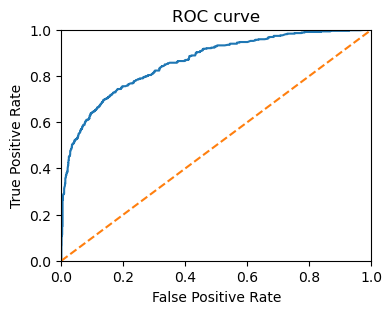

AUC-ROC for Classifier w/ Estimators = 250  Depth = 20 : 0.8614659666692603


In [15]:
model_forest = RandomForestClassifier(random_state = 42, n_estimators = 250, max_depth= 20)

model_forest.fit(features_train, target_train)

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure(figsize=[4,3])
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC curve') 
plt.show()
        
print (f'AUC-ROC for Classifier w/ Estimators = 250  Depth = 20 : {auc_roc}')

In [16]:
best_threshold = 0.5
best_f1 = 0 

for threshold in np.arange(0, 1, 0.0125):
    predicted = probabilities_one_valid > threshold
    tresh_f1 = f1_score(target_valid, predicted)
    if tresh_f1 > best_f1:
        best_f1 = tresh_f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold.round(3)}    F1 Score:    {best_f1}')


predicted = probabilities_one_valid > best_threshold


tn, fp, fn, tp = confusion_matrix(target_valid, predicted).ravel()

bestf1_TPR = tp / (tp + fn)
bestf1_FPR = fp / (fp + tn)


print(f'TPR= {bestf1_TPR}    FPR = {bestf1_FPR}')


Best Threshold: 0.388    F1 Score:    0.6343949044585987
TPR= 0.6029055690072639    FPR = 0.07750472589792061


### Adjusting Thresholds and Class Balance

Smaller threshold increases (0.0 to 1.0 stepwise by 0.00625) was then applied to each of our class balance readjustments. All results are presented below, however notable models include:

- Downsampling 0s to 70% with max F1 at threshold of 0.45
    - F1 Score:    0.635 &  AUC-ROC:  0.863
- Downsampling 0s to 50% with with with max F1 at threshold of 0.5125
    - F1 Score:    0.642 &    AUC-ROC:  0.862
- Upsampling 1s x10 with a with max F1 at threshold of 0.49375
    - F1 Score:    0.6309067688378034  &  AUC_ROC:  0.8610387668572284

While downsampling our negative cases to 50% of training data resulted in the highest F1 score, it did so with a max F1 at a threshold of 0.5125 meaning that it was less inclined to identify positive cases (the metric we want). Because we want to identify all many customers as possible before they leave the bank, we are willing to accept a model that is more aggresive at identifying positive cases. 

Accordingly, downsampling the negative cases to 70% results in a max F1 at a threshold of 0.45. This model is more inclined to predict customers leaving the bank. 

Notably, upsampling positive cases did not result in notable model improvements until positive cases were multiplied 10 fold {1: 12310, 0: 4769}. This increases the risk of overfitting, so unsampled models were not considered. 

In [17]:
probabilities_bal = balanced_model.predict_proba(features_valid)
probabilities_one_bal = probabilities_bal[:, 1]

best_f1 = 0

for threshold in np.arange(0, 1, 0.00625):
        predicted = probabilities_one_bal > threshold
        bal_f1 = f1_score(target_valid, predicted)
        if bal_f1 > best_f1:
            best_f1 = tresh_f1
            best_threshold = threshold

print(f'Best Threshold using Balanced Classes:     {best_threshold.round(6)}    F1 Score:    {best_f1}')
print('AUC_ROC: ',roc_auc_score(target_valid, probabilities_one_bal))

Best Threshold using Balanced Classes:     0.95625    F1 Score:    0.004830917874396135
AUC_ROC:  0.8654618106253749


In [18]:
for name, method, frac in rebal_methods:
    x_rebal, y_rebal = features_train, target_train
    if method == 'under':
        x_rebal, y_rebal = downsample_zeros(x_rebal, y_rebal,frac)
        rebal_model = RandomForestClassifier(random_state = 42, n_estimators = 250, max_depth= 20)
        rebal_model.fit(x_rebal, y_rebal)

    elif method == 'over':
        x_rebal, y_rebal = upsample_ones(x_rebal, y_rebal,frac)
        rebal_model = RandomForestClassifier(random_state = 42, n_estimators = 250, max_depth= 20)
        rebal_model.fit(x_rebal, y_rebal)

    best_threshold = 0.5
    best_f1 = 0 

    probabilities_valid = rebal_model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    for threshold in np.arange(0, 1, 0.00625):
        predicted = probabilities_one_valid > threshold
        tresh_f1 = f1_score(target_valid, predicted)
        if tresh_f1 > best_f1:
            best_f1 = tresh_f1
            best_threshold = threshold
    
    print(f'Best Threshold using {name}:     {best_threshold.round(6)}    F1 Score:    {best_f1}')
    print('AUC_ROC: ',roc_auc_score(target_valid, probabilities_one_valid))
    print()

Best Threshold using Downsample 0s to 70%:     0.45    F1 Score:    0.6345177664974619
AUC_ROC:  0.8625660061852432

Best Threshold using Downsample 0s to 50%:     0.5125    F1 Score:    0.6416978776529338
AUC_ROC:  0.8622646777463989

Best Threshold using Downsample 0s to 20%:     0.73125    F1 Score:    0.6034255599472991
AUC_ROC:  0.8522323478749099

Best Threshold using Upsample 1s x2:     0.46875    F1 Score:    0.6284224250325945
AUC_ROC:  0.8594680446912032

Best Threshold using Upsample 1s x5:     0.4125    F1 Score:    0.62877030162413
AUC_ROC:  0.8636568914195392

Best Threshold using Upsample 1s x10:     0.49375    F1 Score:    0.6309067688378033
AUC_ROC:  0.8610387668572284



## Final Model Testing

In [19]:
x_rebal, y_rebal = downsample_zeros(features_train, target_train, 0.7)
final_model = RandomForestClassifier(random_state = 42, n_estimators = 250, max_depth=20)
final_model.fit(x_rebal, y_rebal)

probabilities_test = final_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
predicted_test = probabilities_one_test > 0.45
final_f1 = f1_score(target_test, predicted_test)

print(f'F1 of Final Model: {final_f1}')

probabilities_valid = final_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = probabilities_one_valid > 0.45

val_tn, val_fp, val_fn, val_tp = confusion_matrix(target_valid, predicted_valid).ravel()
val_TPR = val_tp / (val_tp + val_fn)
val_FPR = val_fp / (val_fp + val_tn)
print(f'Validation TPR= {val_TPR.round(3)}    Validation FPR = {val_FPR.round(3)}')

tn, fp, fn, tp = confusion_matrix(target_test, predicted_test).ravel()
test_TPR = tp / (tp + fn)
test_FPR = fp / (fp + tn)

print(f'Final Test TPR = {test_TPR.round(3)}    Final Test FPR = {test_FPR.round(3)}')

F1 of Final Model: 0.6197916666666666
Validation TPR= 0.605    Validation FPR = 0.079
Final Test TPR = 0.606    Final Test FPR = 0.085


# Conclusion

For the reasons mentioned above, the final parameters chosen for our model were:
- Downsampling negative cases to 70% of total training data
- n-estimators = 250
- max_depth = 20
- Prediction Threshold for Positive Case: 0.45

When test against the reserved testing data, our model yeildied a F1 score of 0.620, exceeding our accuracy measure of 0.59.

While our score is lower than prior F1 tests, this can be attributed to a higher FPR (0.085 v 0.079 from validation testing) and a slightly improved TPR (0.606 v 0.605 from validation testing). In the context of our project, where wish to identify more potential customers who may leave, this is a desirable outcome. As similar positive cases were correctly identified in validation and final testing, our model passes the sanity test. 

Having passed final accuracy and sanity testing, out model is ready for delivery to our retention project teams. 
